In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# !wget -nc 140.114.76.113:8000/pA1.csv 
# !wget -nc 140.114.76.113:8000/pA2.csv

# !wget -nc 140.114.77.221:8000/ccpd6000.zip
!wget -nc 140.114.77.221:8000/pA1.csv
!wget -nc 140.114.77.221:8000/pA2.csv

File ‘pA1.csv’ already there; not retrieving.

File ‘pA2.csv’ already there; not retrieving.



In [0]:
seed = 999
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
class Data:
    def __init__(self, csv_path):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records')

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        ann = self.anns[idx]
        x = torch.tensor(ann['x'])
        y = torch.tensor(ann['y'])

        return x, y




In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.rand(1) * 0.001)
        self.b = nn.Parameter(torch.rand(1) * 0.001)
    
    def forward(self, xs):
        ps = self.a * xs + self.b

        return ps

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_features = 1
        self.out_features = 1

        # validation
        # self.a = nn.Parameter(torch.rand(1) * 0.001)
        # self.b = nn.Parameter(torch.rand(1) * 0.001)
        # self.c = nn.Parameter(torch.rand(1) * 0.001)

        # # self.weight = nn.Parameter(torch.Tensor(1, 1))

        self.w1 = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        self.w2 = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        self.bias = nn.Parameter(torch.Tensor(self.out_features))
    
    def forward(self, xs):
        # validation
        # ps = self.a * xs * xs + self.b * xs + self.c

        # print(xs)
        # print("---")
        # print(ps)
        # print("==============")
        # # ps = nn.Linear(1, 1)

        xs_double = xs * xs
        ps1 = F.linear(xs_double, self.w1, bias=None)
        ps2 = F.linear(xs, self.w2, self.bias)
        ps = ps1 + ps2

        # ps = torch.cat((ps1, ps2))

        return ps

In [0]:
def data1():
    data = Data('./pA1.csv')
    # plt.scatter(data)
    loader = DataLoader(data, batch_size=5)
    # loader = DataLoader(data, batch_size=50)

    device = 'cpu'
    model = Net().to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

    history = {
        'loss': [],
        'a': [],
        'b': []
    }

    test = []
    data_x = []
    data_y = []
    output = []

    # range(50)
    runtime = 50
    for epoch in range(runtime):
        for xs, ys in iter(loader):
            xs = xs.to(device)
            ys = ys.to(device)
            
            # data_x += xs.tolist()
            # data_y += ys.tolist()

            optimizer.zero_grad()
            ps = model(xs)
            loss = criterion(ps, ys)
            loss.backward()
            optimizer.step()

            history['loss'].append(loss.detach().item())
            history['a'].append(model.a.item())
            history['b'].append(model.b.item())

            # # print(model.a.item() * xs + model.b.item())
            # pred_y = model.a.item() * xs + model.b.item()
            # output.append(pred_y.tolist())

            # # plt.plot(ps.tolist(), color='red', linewidth=2)

            # output = history['a'].tolist() * xs + history['b'].tolist()

        # plt.title('epoch:'+str(epoch))
    plt.title("Loss")
    plt.plot(history['loss'])
    plt.show()

        # plt.title('epoch:'+str(epoch))
        # plt.plot(history['a'])
        # plt.show()
        # plt.scatter(xs, ys)
        # plt.show()
    # print(len(history['a']))

    pred = []
    for xs, ys in iter(loader):
        xs = xs.to(device)
        ys = ys.to(device)

        data_x += xs.tolist()
        data_y += ys.tolist()

        ps = model(xs)
        pred += ps.tolist()

    # print(len(data_x))

    # for i, j in iter(loader):
    #     # print(i)
    #     output.append(model(i).tolist())

    # # ps = ps.detach().numpy()
    # print(output.shpae)

    plt.title("epoch:"+str(runtime))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.scatter(data_x, data_y)
    # plt.plot(data_x, data_y, ps.tolist(), color='red', linewidth=2)
    plt.plot(data_x, pred, color='red')
    plt.show()

    # print(type(ps))

    print(model.a)
    print(model.b)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    # X = history['a']
    # Y = history['b']
    # Z = history['loss']

    a = history['a']
    b = history['b']
    loss = history['loss']
    ax.plot(a, b, loss, color="black")

    x = np.linspace(-1, 6, 25)
    y = np.linspace(-1, 6, 25)
    X, Y = np.meshgrid(x, y)
    L = np.zeros((25, 25))

    
    # draw_reads = pd.read_csv(csv_path).to_dict('records')
    for i, Ii in enumerate(X):
        for j, Jj in enumerate(Y):
            total_loss = 0
            for xs, ys in iter(loader):

                xs = xs.to(device)
                ys = ys.to(device)

                ps = X[i, j] * xs + Y[i, j]
                loss = criterion(ps, ys)

                total_loss += loss
            L[i][j] = total_loss/(len(data)/5)

    # ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none')
    # Plot the surface.

    surf = ax.plot_surface(X, Y, L, cmap='jet', alpha=0.5, antialiased=False)
    ax.set_title('Surface plot')
    ax.view_init(40, -30)
    plt.show()


In [0]:
def data2():
    data2 = Data('./pA2.csv')
    loader2 = DataLoader(data2, batch_size=1)
    # print(type(loader))

    x_pre = []
    y_pre = []

    for xs, ys in iter(loader2):
        x_pre += xs.tolist()
        y_pre += ys.tolist()

    # new = [(x_pre[i], y_pre[i]) for i in range(len(x_pre))]
    # new.sort(reverse=False)
    # print(new)


    device = 'cpu'
    model2 = Net2().to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model2.parameters(), lr=1e-2)

    history = {
        'loss': [],
        'a': [],
        'b': [],
        'c': []
    }

    data_x = []
    data_y = []

    runtime2 = 50
    for epoch in range(runtime2):
        for xs, ys in iter(loader2):
            xs = xs.to(device)
            ys = ys.to(device)

            # print(xs)

            optimizer.zero_grad()
            ps = model2(xs)
            loss = criterion(ps, ys)
            loss.backward()
            optimizer.step()

        history['loss'].append(loss.detach().item())
        # history['a'].append(model2.a.item())
        # history['b'].append(model2.b.item())
        # history['c'].append(model2.c.item())

    plt.title("Loss")
    plt.plot(history['loss'])
    plt.show()

    pred = []
    for xs, ys in iter(loader2):

        xs = xs.to(device)
        ys = ys.to(device)
        
        data_x += xs.tolist()
        data_y += ys.tolist()        

        ps = model2(xs)
        pred += ps.tolist()

    # data_x.sort(reverse=False)
    # data_y.sort(reverse=False)
    # pred.sort(reverse=False)

    new2 = [(x_pre[i], pred[i]) for i in range(len(x_pre))]
    new2.sort(reverse=False)

    pred_x = []
    pred_sort_y = []
    for i in range(len(new2)):
        # pred_x += new2[i][0]
        # pred_sort_y += new2[i][1]
        pred_x.append(new2[i][0])
        pred_sort_y.append(new2[i][1])
        # print(new2[i][1])

    plt.title("epoch:"+str(runtime2))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.scatter(data_x, data_y)
    plt.plot(pred_x, pred_sort_y, color='red')
    plt.show()

    # print(type(ps))

    print(model2.w1)
    print(model2.w2)
    print(model2.bias)

    # print(model2.a)
    # print(model2.b)
    # print(model2.c)



------------------------- A1 ------------------------


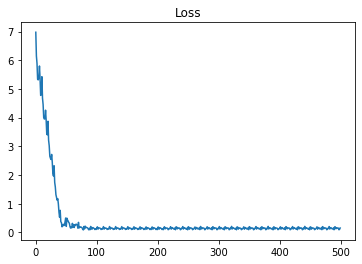

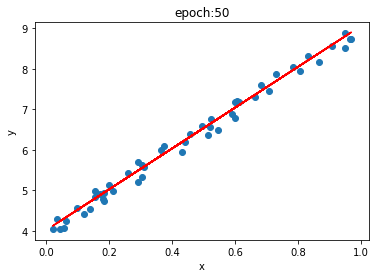

Parameter containing:
tensor([5.0393], requires_grad=True)
Parameter containing:
tensor([4.0182], requires_grad=True)


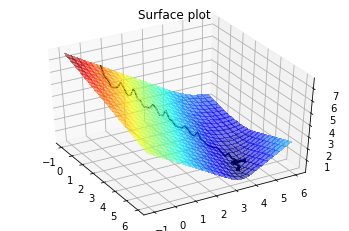


------------------------- A2 ------------------------


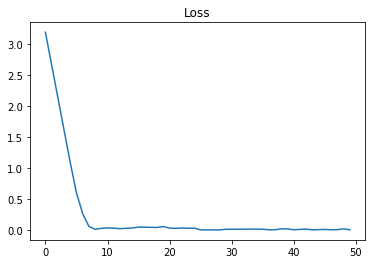

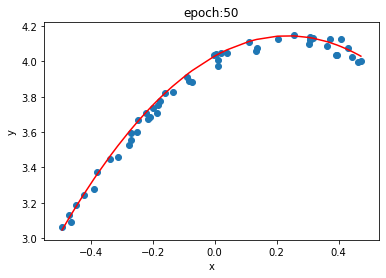

Parameter containing:
tensor([[-2.0692]], requires_grad=True)
Parameter containing:
tensor([[0.9753]], requires_grad=True)
Parameter containing:
tensor([4.0299], requires_grad=True)


In [17]:
if __name__ == '__main__':
    print()
    print("------------------------- A1 ------------------------")
    data1()
    print()
    print("------------------------- A2 ------------------------")
    data2()